In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from itertools import product
from torch import tensor
import pickle
import time

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainset, valset = torch.utils.data.random_split(trainset, [45000, 5000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [5]:
resume = True

if resume: 
    with open('sgd_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [10]:
test_accuracy_history_sgd

{}

In [6]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
    
    lenet = torchvision.models.resnet18(pretrained=False)
    lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
    lenet.maxpool = torch.nn.Identity()
    lenet.cuda()
    loss = torch.nn.CrossEntropyLoss()
    
    optimizer = torch.optim.SGD(lenet.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    test_loss_history_sgd[key] = list()
    test_accuracy_history_sgd[key] = list()
    loss_in_training_sgd[key] = list()
    time_learning_sgd[key] = list()

    for epoch in range(20):
        
        sum_los = 0
        start_time = time.time()
        
        for i, data in enumerate(trainloader, 0):
            
            optimizer.zero_grad()

            X_batch, y_batch = data
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            preds = lenet.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()
            sum_los += float(loss_value)
            optimizer.step()
        
        time_learning_sgd[key].append(time.time() - start_time)
        loss_in_training_sgd[key].append(sum_los/450)
        
        correct = 0
        total = 0
        los = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = lenet.forward(images)
                outputs = outputs.cuda()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                loss_value = loss(outputs, labels)
                total += labels.size(0)
                los += loss_value
                
        test_loss_history_sgd[key].append(los/50)
        print('los epoch', epoch, ':', los/50)
        
        test_accuracy_history_sgd[key].append(correct/total)
        print('accuracy epoch', epoch, ':', correct/total)
                
            
    print(test_accuracy_history_sgd[(learning_rate, weight_decay)])
    print(loss_in_training_sgd[(learning_rate, weight_decay)])
    with open('sgd_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [6]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

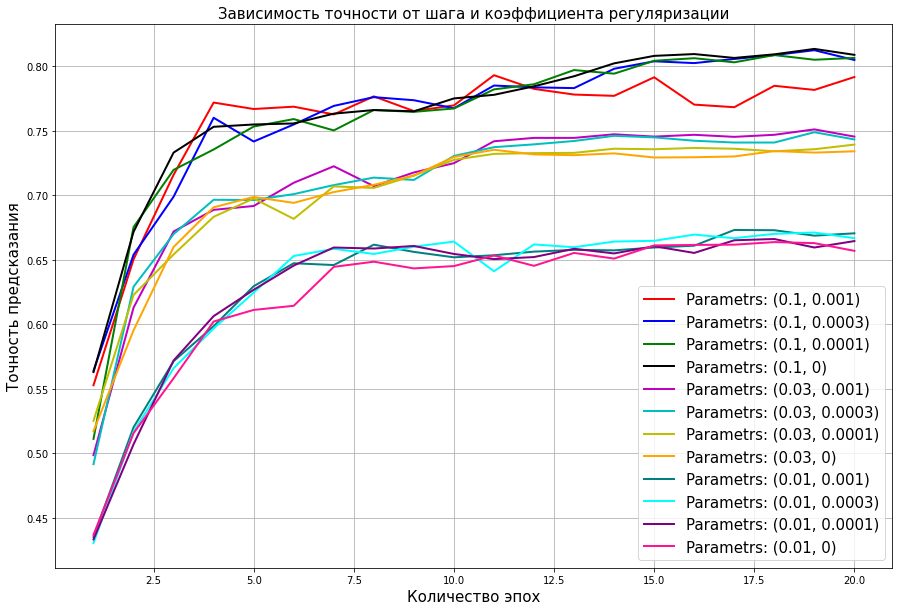

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_accrucy.png')

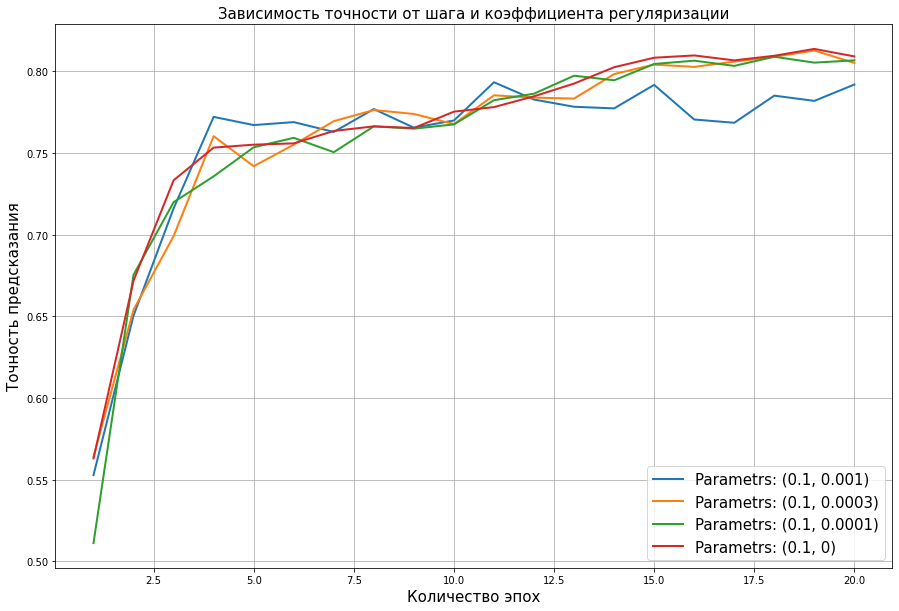

In [13]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(range(1, 21), test_accuracy_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_accrucy_small.png')

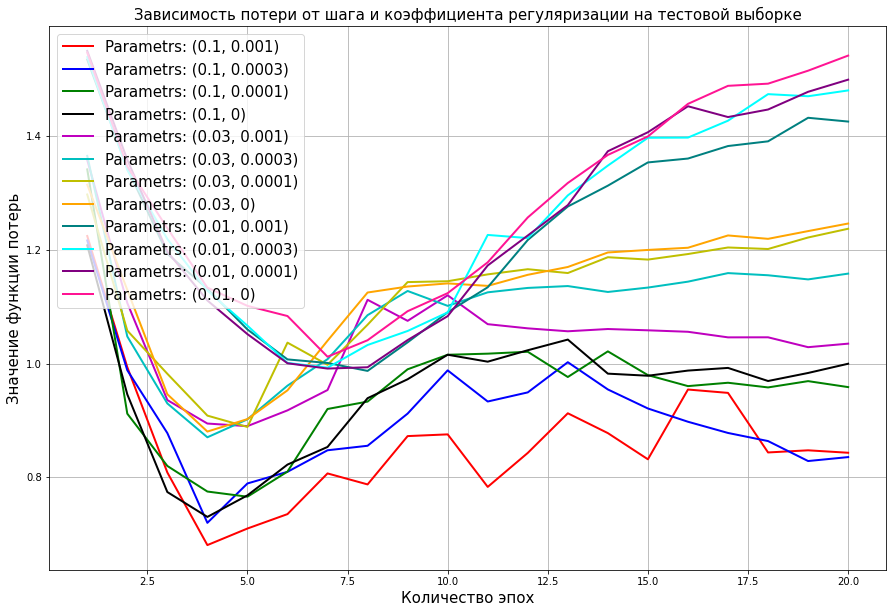

In [14]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sgd.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_2_loss.png')

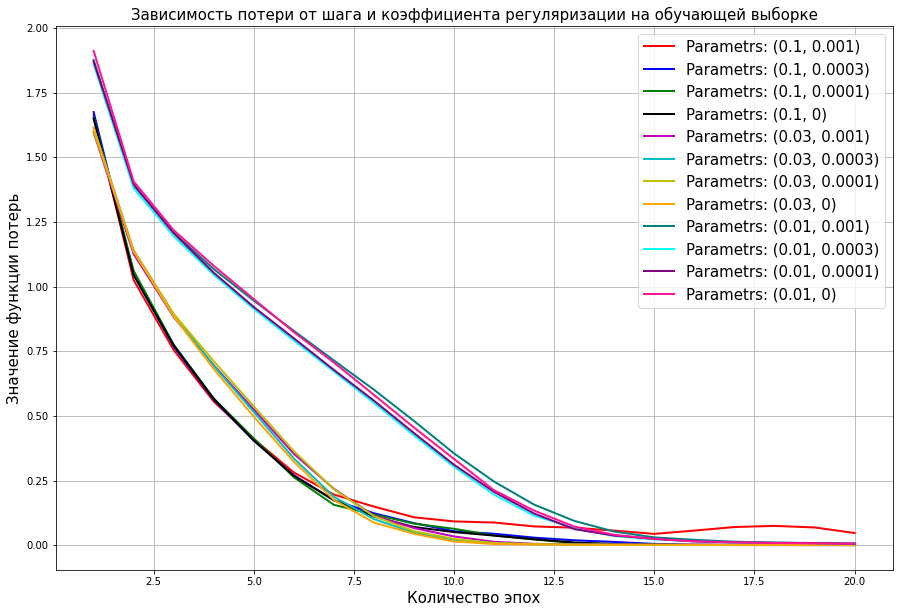

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sgd.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_2_loss_train.png')

In [15]:
time_learning_sgd

{(0.1, 0.001): [28.356867790222168,
  28.606182098388672,
  28.810133695602417,
  28.842174291610718,
  28.90818738937378,
  28.88210964202881,
  28.87302255630493,
  28.89050793647766,
  28.87714171409607,
  28.909587144851685,
  28.963277578353882,
  28.93502402305603,
  28.85673499107361,
  28.818022966384888,
  28.87654399871826,
  28.847254037857056,
  29.038484811782837,
  28.86491894721985,
  28.830143213272095,
  28.80455183982849],
 (0.1, 0.0003): [28.77982473373413,
  28.896733283996582,
  28.798670291900635,
  28.793609380722046,
  28.853801727294922,
  28.759743213653564,
  28.759865045547485,
  28.79727530479431,
  28.719205856323242,
  28.89874243736267,
  28.837194442749023,
  28.88454508781433,
  28.797873497009277,
  28.81686234474182,
  28.75243592262268,
  28.84680986404419,
  28.820533990859985,
  28.903223752975464,
  28.823102951049805,
  28.828089952468872],
 (0.1, 0.0001): [28.860111713409424,
  28.7500102519989,
  28.795114517211914,
  28.831435918807983,
  28.

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
trainset, valset = torch.utils.data.random_split(trainset, [46000, 4000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [9]:
resume = True

if resume: 
    with open('sgd_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [ ]:
lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()
time_learning_sgd = list()

for epoch in range(20):

    sum_los = 0
    start_time = time.time()

    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        sum_los += float(loss_value)
        optimizer.step()

    time_learning_sgd.append(time.time() - start_time)
    loss_in_training_sgd.append(sum_los/460)

    correct = 0
    total = 0
    los = 0
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sgd.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sgd.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sgd)
print(loss_in_training_sgd)
with open('sgd_results.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

In [10]:
time_learning_sgd

[31.101808309555054,
 29.067795038223267,
 29.25159239768982,
 29.312655210494995,
 29.24940013885498,
 29.29863452911377,
 29.298933029174805,
 29.28166961669922,
 29.205780267715454,
 29.36301302909851,
 29.317018270492554,
 29.286094903945923,
 29.35226035118103,
 29.280385494232178,
 29.29620599746704,
 29.320229291915894,
 29.211965322494507,
 29.323944568634033,
 29.292189836502075,
 29.248542547225952]

In [11]:
sum(time_learning_sgd)

587.3601181507111

In [15]:
start_time = time.time()

lenet = torchvision.models.resnet18(pretrained=False)
lenet.conv1 = torch.nn.Conv2d(3, 64, 3, 1, 1, bias=False)
lenet.maxpool = torch.nn.Identity()
lenet.cuda()
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(lenet.parameters(), lr=0.1, weight_decay=0.001)

test_loss_history_sgd_res = list()
test_accuracy_history_sgd_res = list()

for epoch in range(20):
    for i, data in enumerate(trainloader, 0):

        optimizer.zero_grad()

        X_batch, y_batch = data
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        preds = lenet.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()
        optimizer.step()

    correct = 0
    total = 0
    los = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = lenet.forward(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            loss_value = loss(outputs, labels)
            total += labels.size(0)
            los += loss_value


    test_loss_history_sgd_res.append(los/100)
    print('los epoch', epoch, ':', los/100)

    test_accuracy_history_sgd_res.append(correct/total)
    print('accuracy epoch', epoch, ':', correct/total)

print(test_accuracy_history_sgd_res)
with open('results.pkl', 'ab') as f:
    pickle.dump({"sgd_acc": test_accuracy_history_sgd_res, "sgd_loss": test_loss_history_sgd_res}, f)
print("--- %s seconds ---" % (time.time() - start_time))

los epoch 0 : tensor(1.2200, device='cuda:0')
accuracy epoch 0 : 0.5462
los epoch 1 : tensor(0.8940, device='cuda:0')
accuracy epoch 1 : 0.6876
los epoch 2 : tensor(0.7273, device='cuda:0')
accuracy epoch 2 : 0.7436
los epoch 3 : tensor(0.6846, device='cuda:0')
accuracy epoch 3 : 0.7666
los epoch 4 : tensor(0.6715, device='cuda:0')
accuracy epoch 4 : 0.7797
los epoch 5 : tensor(0.7095, device='cuda:0')
accuracy epoch 5 : 0.7799
los epoch 6 : tensor(0.7170, device='cuda:0')
accuracy epoch 6 : 0.7869
los epoch 7 : tensor(0.7648, device='cuda:0')
accuracy epoch 7 : 0.7813
los epoch 8 : tensor(0.7407, device='cuda:0')
accuracy epoch 8 : 0.7967
los epoch 9 : tensor(0.7770, device='cuda:0')
accuracy epoch 9 : 0.7904
los epoch 10 : tensor(0.7604, device='cuda:0')
accuracy epoch 10 : 0.7988
los epoch 11 : tensor(0.7986, device='cuda:0')
accuracy epoch 11 : 0.7919
los epoch 12 : tensor(0.8322, device='cuda:0')
accuracy epoch 12 : 0.7909
los epoch 13 : tensor(0.8623, device='cuda:0')
accuracy ep